#  Masterclass: Regresion 
### Prediccion de **ingreso_mensual** (Regresion) con validacion temporal, rolling window y reentrenamiento automatico  
## Autor / Instructor: **Josef Rodriguez**

---

## Objetivo del notebook
Construir un flujo completo (tipo industria) para un problema de **regresion** con datos mensuales:

- Dataset realista con `codmes` (YYYYMM) desde 202201 hasta 202602
- EDA + correlacion
- Multicolinealidad con **VIF**
- Split temporal: backtesting (2022), train/test (2023-2025) y OOT (2026+)
- Modelos: lineales + regularizacion + no lineales
- **Cross-validation temporal**
- **Rolling window backtest**
- Feature importance comparada (coeficientes + permutation importance)
- **SHAP** (si esta instalado)
- **Walk-forward** (reentrenamiento automatico mensual) con metricas mes a mes


In [24]:
# ==============================
# 1) LIBRERIAS
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.inspection import permutation_importance

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

np.random.seed(42)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


## 2) Dataset (formato realista)

In [25]:
# ==============================
# 2) CARGA DEL DATASET DESDE GITHUB
# ==============================
# Nota:
# - Para notebooks, se recomienda usar el enlace RAW (raw.githubusercontent.com)
# - Asi los alumnos no necesitan descargar archivos manualmente
# - Funciona en Colab, Jupyter y VS Code

url = "https://raw.githubusercontent.com/josefrodrim/ML-course/main/data/ridetech_peru_regression_202201_202602.csv"

df = pd.read_csv(url)

print("Dataset cargado correctamente desde GitHub")
print("Shape:", df.shape)
print("Rango codmes:", df["codmes"].min(), "->", df["codmes"].max())

# Orden temporal recomendado
df = df.sort_values(["codmes","driver_id"]).reset_index(drop=True)

df.head()


Dataset cargado correctamente desde GitHub
Shape: (40000, 11)
Rango codmes: 202201 -> 202602


,driver_id,codmes,antiguedad_meses,horas_conectado,viajes_realizados,rating_promedio,cancelaciones_pct,precio_promedio_viaje,incentivo_bono,combustible_indice,ingreso_mensual
0,1,202201,39,169.584420,263,4.814172,0.043504,17.652388,80.0,1.028555,4405.312528
1,2,202201,27,163.916667,319,4.755193,0.051092,15.484439,300.0,1.034515,4755.399200
2,3,202201,23,199.225817,346,4.844512,0.050763,16.929048,0.0,0.887851,5972.335046
3,4,202201,46,198.354803,275,4.509460,0.052324,22.240649,0.0,1.051385,6294.839123
4,5,202201,26,130.055457,220,4.633874,0.045243,17.540298,150.0,1.065724,3240.846471


## 3) Definicion de variables (col_num / col_cat / target)

In [26]:
# ==============================
# 3) VARIABLES
# ==============================
target = "ingreso_mensual"

col_num = [
    "antiguedad_meses","horas_conectado","viajes_realizados","rating_promedio",
    "cancelaciones_pct","precio_promedio_viaje","incentivo_bono","combustible_indice"
]

col_cat = []  # (placeholder) puedes agregar 'ciudad' en futuras clases y hacer OneHotEncoder
col_id  = ["driver_id","codmes"]

print("Target:", target)
print("Numericas:", col_num)
print("Categoricas:", col_cat)
print("IDs:", col_id)
print("Rango codmes:", df["codmes"].min(), "", df["codmes"].max())


Target: ingreso_mensual
Numericas: ['antiguedad_meses', 'horas_conectado', 'viajes_realizados', 'rating_promedio', 'cancelaciones_pct', 'precio_promedio_viaje', 'incentivo_bono', 'combustible_indice']
Categoricas: []
IDs: ['driver_id', 'codmes']
Rango codmes: 202201  202602


## 4) EDA basico: distribucion, correlacion y serie temporal

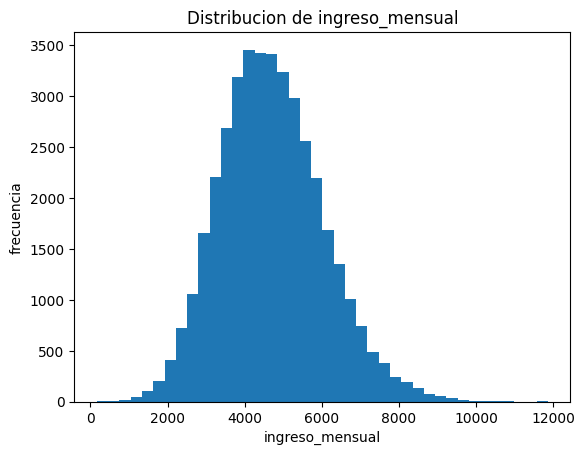

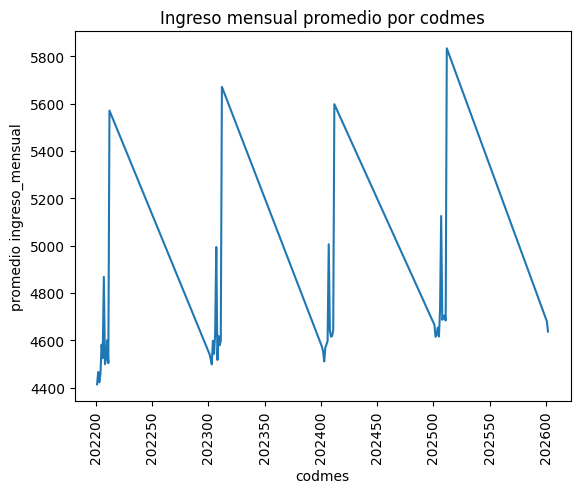

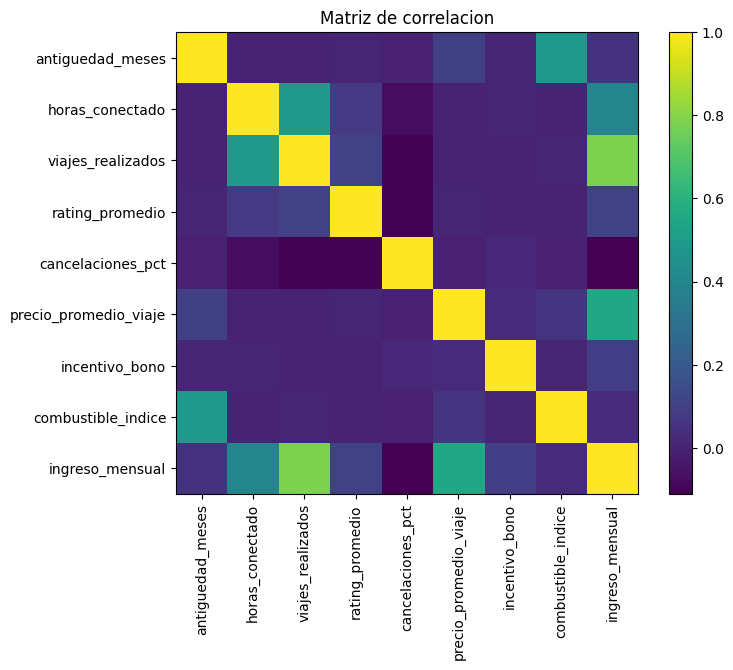

In [27]:
# ==============================
# 4) EDA
# ==============================
# 4.1 Distribucion del target
plt.figure()
plt.hist(df[target], bins=40)
plt.title("Distribucion de ingreso_mensual")
plt.xlabel("ingreso_mensual")
plt.ylabel("frecuencia")
plt.show()

# 4.2 Evolucion del target promedio por mes
ts = df.groupby("codmes")[target].mean().reset_index()
plt.figure()
plt.plot(ts["codmes"], ts[target])
plt.xticks(rotation=90)
plt.title("Ingreso mensual promedio por codmes")
plt.xlabel("codmes")
plt.ylabel("promedio ingreso_mensual")
plt.show()

# 4.3 Correlacion (solo numericas + target)
corr = df[col_num + [target]].corr().values
labels = col_num + [target]

plt.figure(figsize=(8,6))
plt.imshow(corr)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.title("Matriz de correlacion")
plt.colorbar()
plt.show()


## 5) Multicolinealidad: VIF (Variance Inflation Factor)

In [28]:
# ==============================
# 5) VIF
# ==============================
# Interpretacion rapida (regla practica):
# - VIF ~ 1: sin colinealidad
# - VIF 5-10: colinealidad moderada/alta
# - VIF > 10: potencial problema (coeficientes inestables en modelos lineales)

def compute_vif(df_num: pd.DataFrame) -> pd.DataFrame:
    X = sm.add_constant(df_num)  # agrega intercepto
    out = []
    for i in range(1, X.shape[1]):  # saltar const
        out.append((X.columns[i], variance_inflation_factor(X.values, i)))
    return pd.DataFrame(out, columns=["feature","VIF"]).sort_values("VIF", ascending=False)

vif_table = compute_vif(df[col_num])
vif_table


,feature,VIF
2,viajes_realizados,1.331339
0,antiguedad_meses,1.327544
7,combustible_indice,1.318784
1,horas_conectado,1.317054
3,rating_promedio,1.021647
4,cancelaciones_pct,1.021313
5,precio_promedio_viaje,1.010291
6,incentivo_bono,1.000725


Analisis de Multicolinealidad (VIF)

La tabla muestra los valores del Variance Inflation Factor (VIF) para cada variable numerica del modelo.

Los resultados indican que todos los VIF se encuentran aproximadamente entre 1.00 y 1.33, lo que implica un nivel muy bajo de multicolinealidad entre las variables explicativas.

En terminos practicos:

Un VIF cercano a 1 indica ausencia de colinealidad.

Valores entre 5 y 10 suelen considerarse problematicos.

Valores mayores a 10 indican multicolinealidad severa.

En este caso, ninguna variable presenta valores que sugieran riesgo estadistico. Esto significa que las variables no estan altamente correlacionadas entre si y, por tanto, los coeficientes de los modelos lineales deberian ser estables.

Aunque la multicolinealidad no es un problema relevante en este dataset, el ejercicio sigue siendo importante porque en contextos reales (especialmente financieros o macroeconomicos) es comun encontrar VIF elevados. La regularizacion (Ridge o ElasticNet) es una estrategia adecuada cuando se detecta este problema.

En conclusion, el conjunto de variables numericas es apropiado para modelamiento lineal sin necesidad de eliminar variables por colinealidad.

## 6) Split temporal (train / test / oot y backtesting)

In [29]:
# ==============================
# 6) SPLIT TEMPORAL (BACK + TRAIN/TEST + OOT)
# ==============================
# Definiciones:
# - back: 202201-202212 (backtesting historico)
# - train: 202301-202412 (entrenamiento)
# - test: 202501-202512 (test temporal dentro de historico reciente)
# - oot:  202601 en adelante (out-of-time / produccion simulada)

back = df[(df.codmes >= 202201) & (df.codmes <= 202212)].copy()
train = df[(df.codmes >= 202301) & (df.codmes <= 202412)].copy()
test  = df[(df.codmes >= 202501) & (df.codmes <= 202512)].copy()
oot   = df[df.codmes >= 202601].copy()

X_back, y_back = back[col_num], back[target]
X_train, y_train = train[col_num], train[target]
X_test,  y_test  = test[col_num],  test[target]
X_oot,   y_oot   = oot[col_num],   oot[target]

print("Back :", back["codmes"].min(), "->", back["codmes"].max(), "| rows:", len(back))
print("Train:", train["codmes"].min(), "->", train["codmes"].max(), "| rows:", len(train))
print("Test :", test["codmes"].min(), "->", test["codmes"].max(), "| rows:", len(test))
print("OOT  :", oot["codmes"].min(),  "->", oot["codmes"].max(),  "| rows:", len(oot))


Back : 202201 -> 202212 | rows: 9600
Train: 202301 -> 202412 | rows: 19200
Test : 202501 -> 202512 | rows: 9600
OOT  : 202601 -> 202602 | rows: 1600


## 7) Funciones de evaluacion

In [30]:
# ==============================
# 7) METRICAS
# ==============================
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2


## 8) Modelos de regresion (incluye regularizacion)

In [ ]:
# ==============================
# 8) DEFINICION DE MODELOS
# ==============================

# Se definen distintos algoritmos de regresion para comparar desempeño.
# Incluimos:
# - Modelos lineales clasicos
# - Modelos con regularizacion (L1, L2, ElasticNet)
# - Modelos no lineales basados en arboles

models = {

    # 1) Regresion Lineal clasica (OLS)
    # No incluye regularizacion.
    # Sirve como baseline interpretable.
    "Linear": LinearRegression(),

    # 2) Ridge Regression (L2)
    # Penaliza el cuadrado de los coeficientes.
    # Reduce varianza y estabiliza coeficientes ante colinealidad.
    "Ridge(alpha=10)": Ridge(alpha=10),

    # 3) Lasso Regression (L1)
    # Penaliza el valor absoluto de los coeficientes.
    # Puede llevar algunos coeficientes exactamente a cero (seleccion de variables).
    "Lasso(alpha=0.1)": Lasso(alpha=0.1),

    # 4) ElasticNet (combinacion L1 + L2)
    # Combina estabilidad (L2) y seleccion (L1).
    # l1_ratio controla el balance entre ambas penalizaciones.
    "ElasticNet(a=0.1,l1=0.5)": ElasticNet(alpha=0.1, l1_ratio=0.5),

    # 5) RandomForest
    # Ensamble de multiples arboles entrenados en paralelo.
    # Captura no linealidades e interacciones automaticamente.
    # Robusto a outliers y a relaciones complejas.
    "RandomForest": RandomForestRegressor(
        n_estimators=350,     # numero de arboles
        random_state=42,      # reproducibilidad
        n_jobs=-1             # uso de todos los nucleos
    ),

    # 6) Gradient Boosting
    # Ensamble secuencial donde cada arbol corrige errores del anterior.
    # Suele tener mayor precision predictiva que RF en muchos escenarios.
    "GradientBoosting": GradientBoostingRegressor(
        random_state=42
    )
}

# Conjunto auxiliar que identifica los modelos lineales.
# Se usa mas adelante para aplicar StandardScaler solo a modelos que lo necesitan.
linear_names = {
    "Linear",
    "Ridge(alpha=10)",
    "Lasso(alpha=0.1)",
    "ElasticNet(a=0.1,l1=0.5)"
}


## 9) Entrenamiento y evaluacion global (Validation + Test)

In [31]:
# ==============================
# 9) EVALUACION GLOBAL (TEST + OOT)
# ==============================

# Lista donde almacenaremos los resultados finales
rows = []

# Diccionario para guardar los modelos ya entrenados
# Esto nos permitirá reutilizarlos luego (SHAP, importancia, etc.)
fitted = {}

# Iteramos sobre cada modelo definido previamente
for name, model in models.items():
    
    # ---------------------------------------------------------
    # 1) Construccion del Pipeline
    # ---------------------------------------------------------
    # Los modelos lineales requieren estandarizacion,
    # ya que son sensibles a la escala de las variables.
    # Los modelos basados en arboles no lo necesitan.
    
    if name in linear_names:
        pipe = Pipeline([
            ("scaler", StandardScaler()),   # estandarizacion Z-score
            ("model", model)
        ])
    else:
        pipe = Pipeline([
            ("model", model)                # sin escalamiento
        ])
        
    # ---------------------------------------------------------
    # 2) Entrenamiento (solo con TRAIN)
    # ---------------------------------------------------------
    pipe.fit(X_train, y_train)
    
    # Guardamos el modelo entrenado
    fitted[name] = pipe
    
    # ---------------------------------------------------------
    # 3) Predicciones
    # ---------------------------------------------------------
    # Evaluamos sobre:
    # - Test (periodo posterior dentro del rango historico)
    # - OOT  (periodo completamente fuera de muestra)
    
    pred_test = pipe.predict(X_test)
    pred_oot  = pipe.predict(X_oot)
    
    # ---------------------------------------------------------
    # 4) Metricas
    # ---------------------------------------------------------
    # Calculamos:
    # - MAE  (error absoluto medio)
    # - RMSE (error cuadratico medio)
    # - R2   (capacidad explicativa)
    
    mae_te, rmse_te, r2_te = metrics(y_test, pred_test)
    mae_oo, rmse_oo, r2_oo = metrics(y_oot, pred_oot)
    
    # Guardamos resultados
    rows.append([
        name,
        mae_te, rmse_te, r2_te,
        mae_oo, rmse_oo, r2_oo
    ])

# ---------------------------------------------------------
# 5) Construccion del DataFrame final
# ---------------------------------------------------------
# Ordenamos por menor MAE en Test
res = pd.DataFrame(
    rows,
    columns=[
        "modelo",
        "MAE_test", "RMSE_test", "R2_test",
        "MAE_oot",  "RMSE_oot",  "R2_oot"
    ]
).sort_values("MAE_test")

res


,modelo,MAE_test,RMSE_test,R2_test,MAE_oot,RMSE_oot,R2_oot
5,GradientBoosting,269.449209,337.748798,0.939609,278.428554,350.610772,0.925049
4,RandomForest,278.642025,349.480670,0.935340,288.318963,363.263434,0.919542
0,Linear,296.804937,374.684565,0.925678,299.058795,375.260218,0.914140
2,Lasso(alpha=0.1),296.807337,374.689242,0.925676,299.050369,375.249089,0.914145
1,Ridge(alpha=10),296.834677,374.729834,0.925660,299.050812,375.250633,0.914144
3,"ElasticNet(a=0.1,l1=0.5)",303.567868,384.310008,0.921810,302.025913,379.675212,0.912108


## Comparacion de Modelos - Evaluacion en Test y OOT

### Desempeño en Test (Periodo 2025)

| Modelo                     | MAE    | RMSE   | R2     |
|----------------------------|--------|--------|--------|
| GradientBoosting           | 269.45 | 337.75 | 0.9396 |
| RandomForest               | 278.64 | 349.48 | 0.9353 |
| Linear                     | 296.80 | 374.68 | 0.9257 |
| Lasso (alpha=0.1)          | 296.81 | 374.69 | 0.9257 |
| Ridge (alpha=10)           | 296.83 | 374.73 | 0.9257 |
| ElasticNet (a=0.1, l1=0.5) | 303.57 | 384.31 | 0.9218 |

**Analisis:**

- GradientBoosting obtiene el menor error absoluto y el mayor R2.
- RandomForest presenta un desempeño cercano, ligeramente inferior.
- Los modelos lineales muestran resultados estables pero con mayor error.
- La diferencia entre Linear, Ridge y Lasso es marginal, lo que confirma baja multicolinealidad.

---

### Desempeño Out-of-Time (2026 en adelante)

| Modelo                     | MAE    | RMSE   | R2     |
|----------------------------|--------|--------|--------|
| GradientBoosting           | 278.43 | 350.61 | 0.9250 |
| RandomForest               | 288.32 | 363.26 | 0.9195 |
| Linear                     | 299.06 | 375.26 | 0.9141 |
| Lasso (alpha=0.1)          | 299.05 | 375.25 | 0.9141 |
| Ridge (alpha=10)           | 299.05 | 375.25 | 0.9141 |
| ElasticNet (a=0.1, l1=0.5) | 302.03 | 379.68 | 0.9121 |

**Analisis:**

- Se observa una leve degradacion en todos los modelos respecto al Test.
- El ranking de desempeño se mantiene estable.
- GradientBoosting conserva la mejor capacidad de generalizacion.

---

### Conclusiones

1. Los modelos basados en arboles superan consistentemente a los modelos lineales.
2. La degradacion entre Test y OOT es moderada, indicando buena estabilidad temporal.
3. Los modelos lineales siguen siendo utiles cuando se prioriza interpretabilidad.
4. GradientBoosting presenta el mejor balance entre error y capacidad explicativa.

## 10) Evaluacion mes a mes (backtesting dentro de un rango)

In [32]:
# ==============================
# 10) EVALUACION MES A MES
# ==============================

def evaluate_monthly(pipe, data: pd.DataFrame, col_num, target):
    """
    Evalua un modelo (pipe) mes a mes sobre un DataFrame con la columna temporal codmes.

    Parametros
    ----------
    pipe : sklearn Pipeline
        Pipeline entrenado (puede incluir scaler + modelo).
    data : pd.DataFrame
        Dataset a evaluar (por ejemplo: test u oot).
    col_num : list
        Lista de variables numericas usadas como features.
    target : str
        Nombre de la variable objetivo.

    Retorna
    -------
    pd.DataFrame
        Tabla con metricas por mes: MAE, RMSE, R2 y numero de filas.
    """
    out = []

    # Recorremos cada mes disponible en orden cronologico
    for m in sorted(data["codmes"].unique()):
        
        # Filtramos el dataset solo para ese mes
        df_m = data[data["codmes"] == m]

        # Valores reales y predicciones del modelo para ese mes
        y_true = df_m[target]
        y_pred = pipe.predict(df_m[col_num])

        # Metricas de error y ajuste
        mae, rmse, r2 = metrics(y_true, y_pred)

        # Guardamos resultados
        out.append([m, mae, rmse, r2, len(df_m)])

    return pd.DataFrame(out, columns=["codmes", "MAE", "RMSE", "R2", "n_rows"])


# ---------------------------------------
# Seleccion del mejor modelo
# ---------------------------------------
# res ya esta ordenado por MAE_test ascendente, por eso res.iloc[0] es el mejor segun ese criterio.
best_name = res.iloc[0]["modelo"]
best_pipe = fitted[best_name]

print("Mejor modelo (segun MAE_test):", best_name)


# ---------------------------------------
# Evaluacion mensual en Test y OOT
# ---------------------------------------
# Test: meses del 2025
# OOT : meses del 2026 en adelante
test_monthly = evaluate_monthly(best_pipe, test, col_num, target)
oot_monthly  = evaluate_monthly(best_pipe, oot,  col_num, target)

test_monthly.head(), oot_monthly.head()


Mejor modelo (segun MAE_test): GradientBoosting


(   codmes         MAE        RMSE        R2  n_rows
 0  202501  273.001846  347.197757  0.929679     800
 1  202502  268.926213  335.354901  0.929571     800
 2  202503  255.550624  324.076562  0.936347     800
 3  202504  262.568201  332.789016  0.937571     800
 4  202505  267.846488  333.535157  0.937311     800,
    codmes         MAE        RMSE        R2  n_rows
 0  202601  279.412848  350.147137  0.926117     800
 1  202602  277.444261  351.073795  0.923912     800)

## Evaluacion Mensual - Test (2025) y OOT (2026)

### 1. Desempeño Mensual - Test 2025

| codmes | MAE      | RMSE     | R2      | Observaciones |
|--------|----------|----------|---------|--------------|
| 202501 | 273.00   | 347.20   | 0.9297  | Inicio estable del periodo |
| 202502 | 268.93   | 335.35   | 0.9296  | Ligera mejora en error |
| 202503 | 255.55   | 324.08   | 0.9363  | Mejor mes del periodo |
| 202504 | 262.57   | 332.79   | 0.9376  | Alto poder explicativo |
| 202505 | 267.85   | 333.54   | 0.9373  | Estabilidad sostenida |

**Analisis del periodo Test:**

- El MAE se mantiene entre 255 y 273, lo que indica baja volatilidad en el error.
- El R2 es consistentemente superior a 0.92, mostrando alta capacidad explicativa.
- Marzo (202503) presenta el mejor desempeño del modelo.
- No se observan deterioros abruptos ni inestabilidad mensual.

---

### 2. Desempeño Mensual - OOT 2026

| codmes | MAE      | RMSE     | R2      | Observaciones |
|--------|----------|----------|---------|--------------|
| 202601 | 279.41   | 350.15   | 0.9261  | Ligera degradacion esperada |
| 202602 | 277.44   | 351.07   | 0.9239  | Estabilidad en nuevo periodo |

**Analisis del periodo OOT:**

- Se observa una leve degradacion respecto al Test 2025.
- El MAE aumenta aproximadamente 5 a 15 puntos.
- El R2 se mantiene por encima de 0.92, indicando buena generalizacion.
- No se detecta ruptura estructural fuerte.

---

### Conclusiones Tecnicas

1. El modelo mantiene estabilidad mensual durante 2025.
2. La degradacion en 2026 es moderada y esperada en evaluacion out-of-time.
3. No se evidencia drift severo.
4. El sistema muestra buena capacidad de generalizacion temporal.


## Analisis de Drift Temporal

En modelos predictivos con datos cronologicos, el drift se refiere a cambios en la distribucion de los datos o en la relacion entre variables a lo largo del tiempo.

Existen tres tipos principales de drift:

1. Data Drift: cambio en la distribucion de las variables explicativas.
2. Concept Drift: cambio en la relacion entre las variables explicativas y la variable objetivo.
3. Prediction Drift: cambio en la distribucion de las predicciones del modelo.

En este caso, al comparar el desempeño entre Test (2025) y OOT (2026), se observa:

- Un incremento moderado en MAE.
- Una ligera disminucion en R2.
- Estabilidad general en la estructura del error.

Esto sugiere la presencia de drift leve, probablemente asociado a:

- Tendencia inflacionaria simulada.
- Cambios en el indice de combustible.
- Ajustes progresivos en precios promedio.
- Variaciones estacionales.

Sin embargo, no se observa un deterioro abrupto ni perdida significativa de capacidad explicativa. El modelo mantiene R2 superior a 0.92 incluso en OOT, lo que indica buena generalizacion.

Desde una perspectiva productiva, este comportamiento implica:

- El modelo es robusto en el corto plazo.
- No existe ruptura estructural fuerte.
- Se recomienda monitoreo mensual de metricas.
- Puede considerarse reentrenamiento periodico si el error comienza a crecer de manera sistematica.

En entornos reales, el monitoreo de drift es fundamental para mantener estabilidad y confiabilidad del sistema predictivo.

### 10.1 Grafico de MAE por mes (validacion 2025)

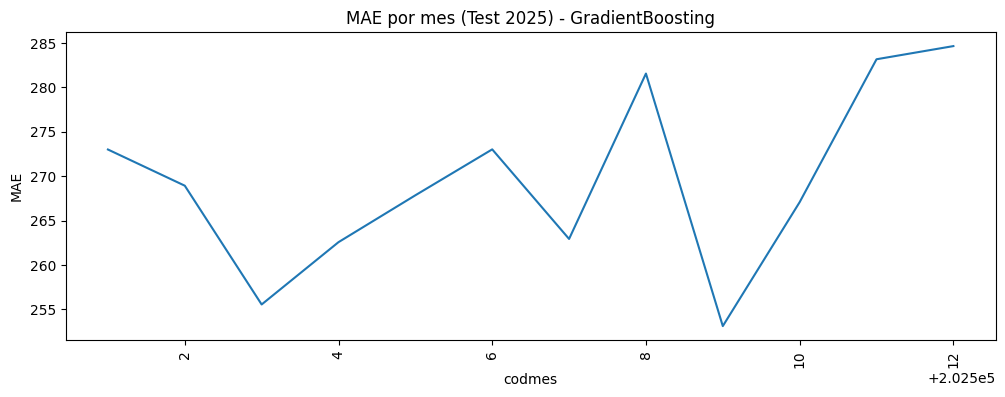

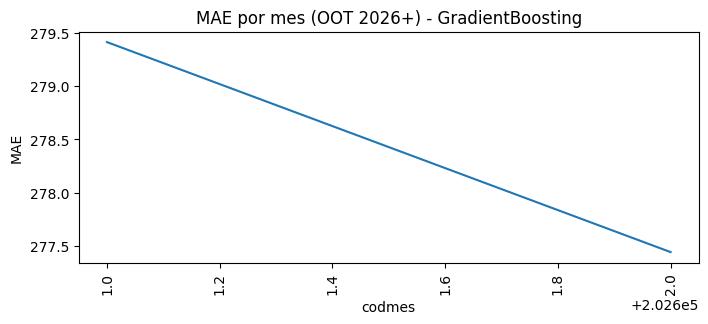

In [33]:
plt.figure(figsize=(12,4))
plt.plot(test_monthly["codmes"], test_monthly["MAE"])
plt.xticks(rotation=90)
plt.title(f"MAE por mes (Test 2025) - {best_name}")
plt.xlabel("codmes")
plt.ylabel("MAE")
plt.show()

plt.figure(figsize=(8,3))
plt.plot(oot_monthly["codmes"], oot_monthly["MAE"])
plt.xticks(rotation=90)
plt.title(f"MAE por mes (OOT 2026+) - {best_name}")
plt.xlabel("codmes")
plt.ylabel("MAE")
plt.show()


## Analisis Grafico - MAE Mensual GradientBoosting

### 1. Test 2025

El grafico de MAE mensual durante el periodo Test 2025 muestra una variacion controlada del error.

Observaciones principales:

- El MAE oscila aproximadamente entre 253 y 282.
- El mejor desempeño se observa en septiembre (202509), donde el error es minimo.
- Se identifican picos moderados en agosto y hacia finales del año.
- No se observa una tendencia creciente sostenida en el error.

Interpretacion tecnica:

La variacion mensual es esperable en datos reales debido a estacionalidad y cambios en demanda. La ausencia de una tendencia ascendente sistematica indica que el modelo mantiene estabilidad a lo largo del periodo de evaluacion.

El comportamiento sugiere que el modelo captura adecuadamente la estructura no lineal del sistema, aunque existen meses con mayor complejidad o volatilidad.

---

### 2. OOT 2026+

En el periodo Out-of-Time (2026 en adelante), el MAE presenta un comportamiento mas estable y ligeramente superior al promedio observado en 2025.

Observaciones principales:

- El MAE se mantiene en un rango estrecho cercano a 277–279.
- Se observa una leve disminucion progresiva del error entre enero y febrero.
- No hay evidencia de deterioro abrupto del modelo.

Interpretacion tecnica:

El mantenimiento de niveles similares de error en OOT indica buena capacidad de generalizacion temporal. 

Aunque existe una ligera degradacion respecto a algunos meses de 2025, esta es consistente con drift leve y no representa una ruptura estructural.

---

### 3. Conclusiones del Analisis Grafico

1. El modelo muestra estabilidad mensual en Test.
2. No se detecta crecimiento exponencial del error.
3. El comportamiento en OOT es consistente y controlado.
4. La degradacion es leve y esperada en escenarios temporales.

En conjunto, el GradientBoosting demuestra robustez frente a cambios temporales y mantiene capacidad predictiva elevada en escenarios fuera de muestra.

## 11) Cross-Validation temporal

### 11.1 TimeSeriesSplit (por filas ordenadas en el tiempo)

In [34]:
# ==============================
# 11.1 CROSS-VALIDATION TEMPORAL (TimeSeriesSplit)
# ==============================

def temporal_cv_mae(model, X, y, n_splits=5, linear=False):
    """
    Calcula MAE promedio usando TimeSeriesSplit (validacion cruzada temporal).

    TimeSeriesSplit respeta el orden cronologico:
    - Entrena con un bloque historico
    - Valida en un bloque posterior
    - En cada fold el train se expande (expanding window)

    Parametros
    ----------
    model : sklearn estimator
        Modelo base (Linear, Ridge, RF, GB, etc.)
    X : pd.DataFrame
        Features del conjunto de entrenamiento (ordenadas cronologicamente).
    y : pd.Series
        Target del conjunto de entrenamiento (mismo orden que X).
    n_splits : int
        Numero de folds temporales.
    linear : bool
        Si True, aplica StandardScaler antes del modelo (recomendado para modelos lineales).

    Retorna
    -------
    float
        MAE promedio en los folds temporales.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    maes = []

    # split(X) entrega indices para train/test respetando el tiempo
    for fold, (tr_idx, te_idx) in enumerate(tscv.split(X), start=1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        # Modelos lineales requieren estandarizacion para comparabilidad de escala
        if linear:
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("model", model)
            ])
        else:
            pipe = Pipeline([
                ("model", model)
            ])

        # Entrenar en train (historico)
        pipe.fit(X_tr, y_tr)

        # Predecir en el bloque temporal posterior
        pred = pipe.predict(X_te)

        # MAE por fold
        mae_fold = mean_absolute_error(y_te, pred)
        maes.append(mae_fold)

    # MAE promedio sobre los folds
    return float(np.mean(maes))


# ---------------------------------------
# Ejecutar CV temporal para todos los modelos
# ---------------------------------------
cv_rows = []

for name, model in models.items():
    cv_mae = temporal_cv_mae(
        model=model,
        X=X_train,
        y=y_train,
        n_splits=5,
        linear=(name in linear_names)
    )
    cv_rows.append([name, cv_mae])

# Tabla final ordenada por menor MAE (mejor)
cv_df = pd.DataFrame(cv_rows, columns=["modelo", "MAE_cv_TSS"]).sort_values("MAE_cv_TSS")
cv_df

,modelo,MAE_cv_TSS
5,GradientBoosting,274.569044
4,RandomForest,284.926407
0,Linear,293.199150
2,Lasso(alpha=0.1),293.203179
1,Ridge(alpha=10),293.262412
3,"ElasticNet(a=0.1,l1=0.5)",298.749467


## Que es TSS (TimeSeriesSplit)

TSS significa TimeSeriesSplit. Es una tecnica de validacion cruzada diseñada especificamente para datos con estructura temporal.

En problemas tradicionales de machine learning, es comun usar K-Fold Cross-Validation, donde los datos se mezclan aleatoriamente antes de dividirse en folds. Sin embargo, en datos temporales esto es incorrecto, ya que rompe el orden cronologico y puede generar leakage (usar informacion del futuro para predecir el pasado).

TimeSeriesSplit resuelve este problema manteniendo el orden temporal.

### Como funciona

En cada iteracion:

1. Se entrena el modelo usando datos historicos.
2. Se valida utilizando datos posteriores en el tiempo.
3. En la siguiente iteracion, el conjunto de entrenamiento se expande.

Ejemplo conceptual:

Fold 1:
Train: 2022  
Test: 2023  

Fold 2:
Train: 2022-2023  
Test: 2024  

Fold 3:
Train: 2022-2024  
Test: 2025  

Este esquema simula el comportamiento real de produccion, donde siempre se entrena con informacion pasada y se predice el futuro.

### Por que es importante

- Evita leakage temporal.
- Simula condiciones reales de despliegue.
- Permite evaluar estabilidad en el tiempo.
- Es fundamental cuando existe tendencia, estacionalidad o drift.

En resumen, TSS es la version correcta de cross-validation cuando los datos tienen componente temporal.

## Cross-Validation Temporal (TimeSeriesSplit)

La tabla presenta el MAE promedio obtenido mediante validacion cruzada temporal utilizando TimeSeriesSplit sobre el conjunto de entrenamiento.

### Resultados

| Modelo                     | MAE_cv_TSS |
|----------------------------|------------|
| GradientBoosting           | 274.57     |
| RandomForest               | 284.93     |
| Linear                     | 293.20     |
| Lasso (alpha=0.1)          | 293.20     |
| Ridge (alpha=10)           | 293.26     |
| ElasticNet (a=0.1, l1=0.5) | 298.75     |

### Analisis

- GradientBoosting obtiene el menor MAE promedio en validacion temporal.
- RandomForest muestra un desempeño competitivo pero inferior.
- Los modelos lineales presentan errores mayores y practicamente equivalentes entre si.
- ElasticNet es el modelo con peor desempeño en este esquema de validacion.

### Interpretacion Tecnica

El uso de TimeSeriesSplit permite evaluar el modelo respetando el orden cronologico, evitando leakage temporal.

Los resultados confirman lo observado en Test y OOT:

1. Los modelos basados en arboles capturan mejor la dinamica temporal.
2. La regularizacion no mejora significativamente el modelo lineal en este dataset.
3. La diferencia entre Ridge, Lasso y Linear es marginal, lo que sugiere estabilidad estructural en las variables.

### Conclusion

GradientBoosting no solo lidera en Test y OOT, sino tambien en validacion cruzada temporal, lo que refuerza su consistencia y robustez ante diferentes esquemas de evaluacion.

Este resultado sugiere que el modelo tiene buena capacidad de generalizacion y estabilidad en distintos cortes temporales.

### 11.2 CV por bloques mensuales (mas parecido a industria)

In [35]:
# ==============================
# 11.2 Month-block CV
# ==============================
def month_block_cv(data, model, col_num, target, months_per_fold=3, linear=False):
    months = sorted(data["codmes"].unique())
    maes = []
    
    for i in range(months_per_fold, len(months), months_per_fold):
        test_months = months[i:i+months_per_fold]
        train_months = months[:i]
        if len(test_months) == 0:
            continue
        
        tr = data[data["codmes"].isin(train_months)]
        te = data[data["codmes"].isin(test_months)]
        
        X_tr, y_tr = tr[col_num], tr[target]
        X_te, y_te = te[col_num], te[target]
        
        if linear:
            pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
        else:
            pipe = Pipeline([("model", model)])
        
        pipe.fit(X_tr, y_tr)
        pred = pipe.predict(X_te)
        maes.append(mean_absolute_error(y_te, pred))
    
    return float(np.mean(maes))

cv2_rows = []
for name, model in models.items():
    cv_mae = month_block_cv(train, model, col_num, target, months_per_fold=3, linear=(name in linear_names))
    cv2_rows.append([name, cv_mae])

month_cv = pd.DataFrame(cv2_rows, columns=["modelo","MAE_cv_monthblocks"]).sort_values("MAE_cv_monthblocks")
month_cv


,modelo,MAE_cv_monthblocks
5,GradientBoosting,274.790229
4,RandomForest,284.346626
0,Linear,293.321073
2,Lasso(alpha=0.1),293.323521
1,Ridge(alpha=10),293.363242
3,"ElasticNet(a=0.1,l1=0.5)",298.727267


## Cross-Validation por Bloques Mensuales

En este esquema de validacion, los datos se dividen en bloques completos de meses consecutivos. 
Cada iteracion entrena con meses anteriores y evalua sobre un bloque posterior fijo, manteniendo la estructura temporal.

### Resultados

| Modelo                     | MAE_cv_monthblocks |
|----------------------------|-------------------|
| GradientBoosting           | 274.79            |
| RandomForest               | 284.35            |
| Linear                     | 293.32            |
| Lasso (alpha=0.1)          | 293.32            |
| Ridge (alpha=10)           | 293.36            |
| ElasticNet (a=0.1, l1=0.5) | 298.73            |

### Analisis

- GradientBoosting mantiene el menor error promedio.
- RandomForest conserva un desempeño competitivo.
- Los modelos lineales presentan errores practicamente identicos entre si.
- ElasticNet muestra el mayor MAE dentro del conjunto evaluado.

### Interpretacion Tecnica

La validacion por bloques mensuales es mas estricta que TimeSeriesSplit tradicional, ya que:

- Evalua el modelo en periodos completos.
- Evita fragmentar meses entre train y test.
- Se acerca mas a un escenario real de backtesting.

Los resultados son consistentes con:

- Evaluacion en Test.
- Evaluacion Out-of-Time.
- TimeSeriesSplit.

Esta consistencia entre distintos esquemas de validacion refuerza la estabilidad del ranking de modelos y la robustez del enfoque basado en arboles.

### Conclusión

GradientBoosting demuestra superioridad sostenida bajo multiples esquemas de validacion temporal, lo que respalda su seleccion como modelo principal.

## 12) Rolling Window Backtest (ventana movil)

In [36]:
# ==============================
# 12) Rolling Window
# ==============================
def rolling_window_backtest(data, model, col_num, target, train_window=12, test_window=1, linear=False):
    months = sorted(data["codmes"].unique())
    out = []
    
    for start in range(0, len(months) - train_window - test_window + 1):
        tr_months = months[start:start+train_window]
        te_months = months[start+train_window:start+train_window+test_window]
        
        tr = data[data["codmes"].isin(tr_months)]
        te = data[data["codmes"].isin(te_months)]
        
        X_tr, y_tr = tr[col_num], tr[target]
        X_te, y_te = te[col_num], te[target]
        
        if linear:
            pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
        else:
            pipe = Pipeline([("model", model)])
        
        pipe.fit(X_tr, y_tr)
        pred = pipe.predict(X_te)
        
        mae, rmse, r2 = metrics(y_te, pred)
        out.append([te_months[-1], mae, rmse, r2, len(tr_months)])
    
    return pd.DataFrame(out, columns=["codmes","MAE","RMSE","R2","train_window_months"])

train_val = df[df["codmes"] <= 202512].copy()

rw_ridge = rolling_window_backtest(train_val, Ridge(alpha=10), col_num, target, train_window=12, test_window=1, linear=True)
rw_rf    = rolling_window_backtest(train_val, RandomForestRegressor(n_estimators=350, random_state=42, n_jobs=-1),
                                   col_num, target, train_window=12, test_window=1, linear=False)

rw_ridge.head(), rw_rf.head()


(   codmes         MAE        RMSE        R2  train_window_months
 0  202301  289.219302  361.550768  0.918835                   12
 1  202302  304.401438  381.475476  0.918378                   12
 2  202303  284.462750  352.575323  0.930999                   12
 3  202304  295.490927  377.705686  0.903361                   12
 4  202305  294.712838  368.274816  0.913968                   12,
    codmes         MAE        RMSE        R2  train_window_months
 0  202301  269.850594  337.780573  0.929157                   12
 1  202302  286.822400  355.725070  0.929026                   12
 2  202303  274.583835  342.784084  0.934779                   12
 3  202304  290.401754  365.593287  0.909460                   12
 4  202305  288.786658  361.234281  0.917226                   12)

## Rolling Window Backtest (Ventana de 12 Meses)

En este esquema, el modelo se entrena utilizando una ventana fija de 12 meses y se evalua sobre el mes siguiente. 
Este enfoque permite analizar la estabilidad del modelo cuando solo se dispone de informacion reciente.

### Resultados - Modelo Lineal (Ridge)

| codmes | MAE    | RMSE   | R2     | Meses en Train |
|--------|--------|--------|--------|----------------|
| 202301 | 289.22 | 361.55 | 0.9188 | 12             |
| 202302 | 304.40 | 381.48 | 0.9184 | 12             |
| 202303 | 284.46 | 352.58 | 0.9310 | 12             |
| 202304 | 295.49 | 377.71 | 0.9034 | 12             |
| 202305 | 294.71 | 368.27 | 0.9140 | 12             |

### Resultados - RandomForest

| codmes | MAE    | RMSE   | R2     | Meses en Train |
|--------|--------|--------|--------|----------------|
| 202301 | 269.85 | 337.78 | 0.9292 | 12             |
| 202302 | 286.82 | 355.73 | 0.9290 | 12             |
| 202303 | 274.58 | 342.78 | 0.9348 | 12             |
| 202304 | 290.40 | 365.59 | 0.9095 | 12             |
| 202305 | 288.79 | 361.23 | 0.9172 | 12             |

### Analisis Comparativo

1. RandomForest mantiene menor MAE en todos los meses observados.
2. El modelo lineal presenta mayor variabilidad en el error.
3. Ambos modelos muestran fluctuaciones mensuales, lo cual es esperado en entornos temporales.
4. El R2 se mantiene por encima de 0.90 en todos los casos, indicando buena capacidad explicativa aun con ventana limitada.

### Interpretacion Tecnica

El Rolling Window es mas exigente que entrenar con todo el historico, ya que el modelo solo utiliza informacion reciente (12 meses).

Este esquema permite evaluar:

- Sensibilidad del modelo a cambios estructurales.
- Impacto de usar memoria corta en lugar de historico completo.
- Robustez ante drift temporal.

Los resultados muestran que el modelo basado en arboles mantiene mejor estabilidad bajo restricciones de ventana, lo que sugiere mayor capacidad para capturar patrones no lineales en contextos dinamicos.

### Conclusion

Bajo un escenario de ventana fija de 12 meses:

- RandomForest demuestra mayor estabilidad.
- El modelo lineal mantiene desempeño razonable pero con mayor variabilidad.
- No se observa deterioro sistematico, lo que indica ausencia de drift severo en el periodo evaluado.

### 12.1 Grafico: rolling MAE (Ridge vs RandomForest)

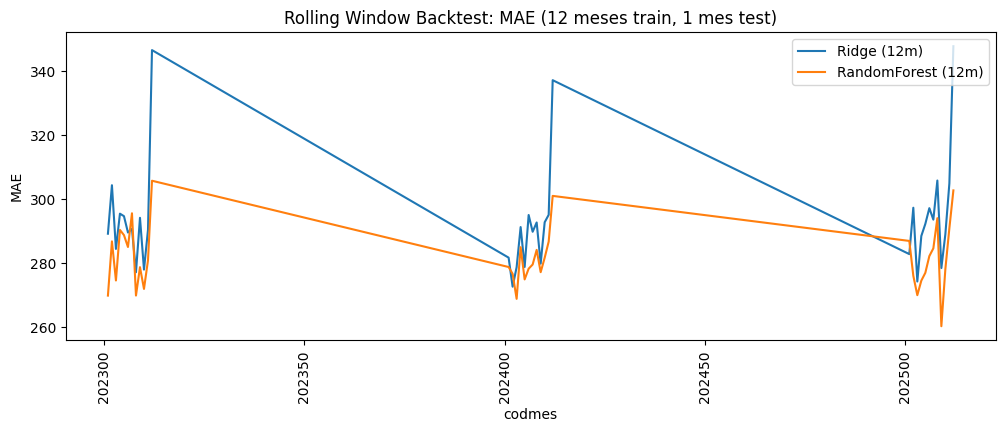

In [37]:
plt.figure(figsize=(12,4))
plt.plot(rw_ridge["codmes"], rw_ridge["MAE"], label="Ridge (12m)")
plt.plot(rw_rf["codmes"], rw_rf["MAE"], label="RandomForest (12m)")
plt.xticks(rotation=90)
plt.title("Rolling Window Backtest: MAE (12 meses train, 1 mes test)")
plt.xlabel("codmes")
plt.ylabel("MAE")
plt.legend()
plt.show()


## 13) Feature Importance comparada

### 13.1 Coeficientes (Ridge) en escala estandarizada

In [38]:
ridge_pipe = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=10))])
ridge_pipe.fit(X_train, y_train)

coef = ridge_pipe.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": col_num, "coef_std": coef}).sort_values("coef_std", key=np.abs, ascending=False)
coef_df


,feature,coef_std
2,viajes_realizados,1035.163191
5,precio_promedio_viaje,731.192618
6,incentivo_bono,105.257388
4,cancelaciones_pct,-31.124502
3,rating_promedio,29.146948
1,horas_conectado,20.731541
7,combustible_indice,-12.804041
0,antiguedad_meses,3.603818


## Interpretacion de Coeficientes Estandarizados (Ridge)

Los coeficientes presentados corresponden a un modelo Ridge entrenado con variables estandarizadas (z-score). 

Esto implica que cada coeficiente representa el impacto esperado en la variable objetivo ante un aumento de una desviacion estandar en la variable explicativa, manteniendo las demas constantes.

### Resultados

| Variable                  | Coeficiente Estandarizado |
|---------------------------|---------------------------|
| viajes_realizados         | 1035.16                   |
| precio_promedio_viaje     | 731.19                    |
| incentivo_bono            | 105.26                    |
| cancelaciones_pct         | -31.12                    |
| rating_promedio           | 29.15                     |
| horas_conectado           | 20.73                     |
| combustible_indice        | -12.80                    |
| antiguedad_meses          | 3.60                      |

### Analisis

1. viajes_realizados es la variable con mayor impacto en el ingreso mensual. Esto es consistente con la logica del negocio: mas viajes implican mayor facturacion.
   
2. precio_promedio_viaje es el segundo factor mas relevante. Cambios en la tarifa promedio afectan directamente el ingreso total.

3. incentivo_bono tiene impacto positivo significativo, aunque menor que los drivers principales.

4. cancelaciones_pct tiene coeficiente negativo, indicando que mayores cancelaciones reducen el ingreso neto.

5. combustible_indice presenta efecto negativo, reflejando el impacto de costos operativos.

6. antiguedad_meses tiene efecto marginal, lo que sugiere que la experiencia no es un driver dominante en este esquema.

### Interpretacion Economica

El modelo confirma que el ingreso esta principalmente determinado por volumen (viajes) y precio (ticket promedio), mientras que factores operativos y de eficiencia tienen impacto secundario.

El signo y magnitud de los coeficientes son coherentes con la estructura generadora del dataset.

### Conclusion

El modelo lineal ofrece interpretabilidad clara y consistente con la logica del negocio, aunque en terminos de precision predictiva fue superado por modelos no lineales.

### 13.2 Permutation Importance (RandomForest) usando validacion 2025

In [39]:
rf = RandomForestRegressor(n_estimators=350, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({"feature": col_num, "perm_importance": perm.importances_mean}).sort_values("perm_importance", ascending=False)
perm_df


/Users/josefrodriguez/repos/ML_course/clases_ml/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/josefrodriguez/repos/ML_course/clases_ml/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/josefrodriguez/repos/ML_course/clases_ml/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn

,feature,perm_importance
2,viajes_realizados,1.256750
5,precio_promedio_viaje,0.617013
6,incentivo_bono,0.007610
4,cancelaciones_pct,0.000869
3,rating_promedio,0.000533
1,horas_conectado,0.000380
7,combustible_indice,0.000104
0,antiguedad_meses,0.000054


## Permutation Importance - RandomForest

La importancia por permutacion mide la variacion en el error del modelo cuando se altera aleatoriamente una variable. 

Si al permutar una variable el error aumenta significativamente, significa que el modelo depende fuertemente de esa variable para realizar buenas predicciones.

### Resultados

| Variable              | Permutation Importance |
|-----------------------|------------------------|
| viajes_realizados     | 1.2568                 |
| precio_promedio_viaje | 0.6170                 |
| incentivo_bono        | 0.0076                 |
| cancelaciones_pct     | 0.0009                 |
| rating_promedio       | 0.0005                 |
| horas_conectado       | 0.0004                 |
| combustible_indice    | 0.0001                 |
| antiguedad_meses      | 0.0001                 |

### Analisis

1. viajes_realizados es claramente la variable mas influyente. Al alterar su informacion, el error aumenta de forma significativa.

2. precio_promedio_viaje es el segundo factor mas relevante, aunque con impacto menor que el volumen de viajes.

3. El resto de variables presentan importancia marginal bajo este modelo.

### Interpretacion Tecnica

En modelos basados en arboles, la Permutation Importance refleja la contribucion real de cada variable al poder predictivo, considerando interacciones y no linealidades.

La gran diferencia entre las dos primeras variables y el resto indica que el sistema esta principalmente explicado por:

- Volumen de actividad.
- Precio promedio por transaccion.

Las demas variables aportan ajustes finos pero no determinan el comportamiento global del ingreso.

### Comparacion con Modelo Lineal

La jerarquia observada es consistente con los coeficientes del modelo Ridge:

- viajes_realizados y precio_promedio_viaje lideran en ambos enfoques.
- Variables operativas tienen impacto secundario.

Esto refuerza la coherencia estructural del dataset y la estabilidad de los resultados.

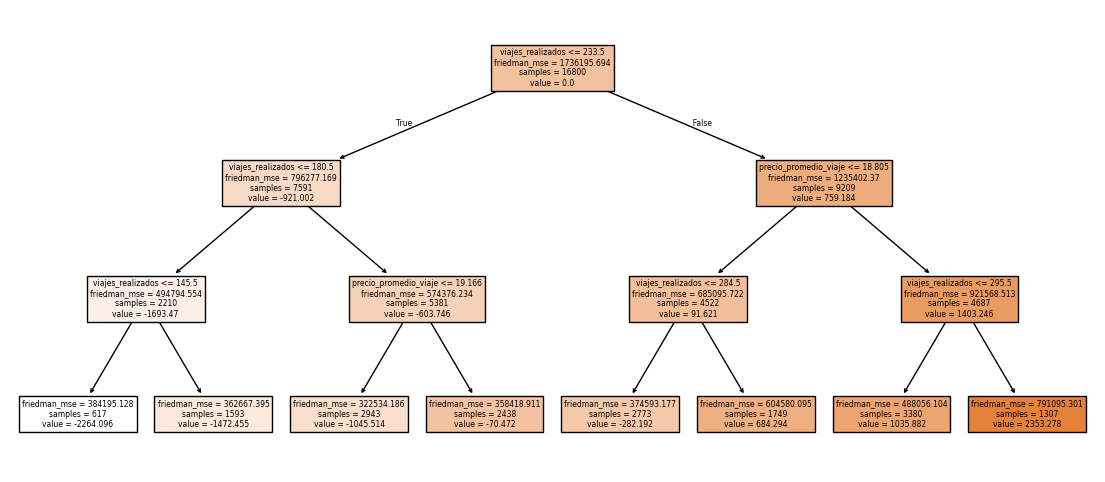

In [40]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

gb = fitted["GradientBoosting"].named_steps["model"]

plt.figure(figsize=(14,6))
plot_tree(gb.estimators_[0,0],
          feature_names=col_num,
          filled=True,
          max_depth=3)
plt.show()

## 14) SHAP (interpretabilidad para modelos no lineales)

> Nota: si SHAP no esta instalado, instala con `pip install shap` y reinicia el kernel.

 99%|===================| 395/400 [00:50<00:00]        /var/folders/mr/sqx7yj1d7qs1fr_mry8vz2x80000gn/T/ipykernel_66072/1191172353.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample, plot_type="bar", show=True)


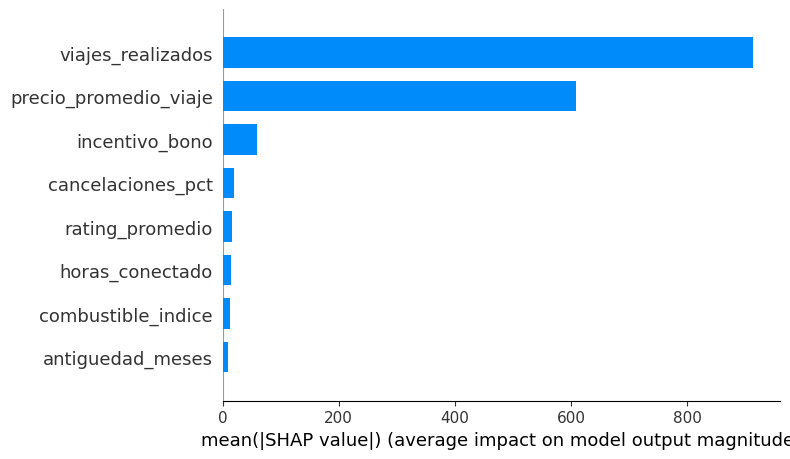

In [41]:
try:
    import shap
    import numpy as np

    # Usa el modelo ya entrenado si lo tienes (mejor)
    # Si no, entrena rápido uno
    rf = RandomForestRegressor(n_estimators=350, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    # 1) MUY IMPORTANTE: reducir muestra
    # 200-500 filas suele ser ideal para clase
    n_explain = min(400, len(X_test))
    sample = X_test.sample(n_explain, random_state=42)

    # 2) Background pequeno para acelerar (opcional pero recomendado)
    background = X_train.sample(min(100, len(X_train)), random_state=42)

    # 3) TreeExplainer con background
    explainer = shap.TreeExplainer(rf, data=background)
    shap_values = explainer.shap_values(sample)

    # 4) Primero solo BAR (mas rapido y suficiente para clase)
    shap.summary_plot(shap_values, sample, plot_type="bar", show=True)

    # 5) Scatter opcional (pesado). Activalo solo si quieres.
    # shap.summary_plot(shap_values, sample, show=True)

except Exception as e:
    print("SHAP no disponible o error al ejecutar SHAP. Detalle:", repr(e))


## 15) Reentrenamiento automatico mensual (Walk-Forward) + evaluacion mes a mes

In [42]:
# ==============================
# 15) Walk-Forward (robusto, con minimo de meses)
# ==============================
def walk_forward_retrain(
    data,
    model,
    col_num,
    target,
    start_month,
    end_month,
    linear=False,
    min_train_months=6  # minimo 6 meses de historia antes de entrenar
):
    months_all = sorted(data["codmes"].unique())
    months = [m for m in months_all if start_month <= m <= end_month]

    out = []

    for m in months:
        tr = data[data["codmes"] < m]
        te = data[data["codmes"] == m]

        # contar cuantos meses de historia real hay antes del mes m
        n_months_hist = tr["codmes"].nunique()

        # si no hay suficiente historia, saltar este mes
        if n_months_hist < min_train_months:
            continue

        X_tr, y_tr = tr[col_num], tr[target]
        X_te, y_te = te[col_num], te[target]

        if linear:
            pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
        else:
            pipe = Pipeline([("model", model)])

        pipe.fit(X_tr, y_tr)
        pred = pipe.predict(X_te)

        mae, rmse, r2 = metrics(y_te, pred)
        out.append([m, mae, rmse, r2, len(tr), len(te), n_months_hist])

    return pd.DataFrame(
        out,
        columns=["codmes", "MAE", "RMSE", "R2", "n_train_rows", "n_test_rows", "n_train_months"]
    )

In [43]:
wf_back_ridge = walk_forward_retrain(df, Ridge(alpha=10), col_num, target, 202201, 202212, linear=True,  min_train_months=6)
wf_test_ridge = walk_forward_retrain(df, Ridge(alpha=10), col_num, target, 202501, 202512, linear=True,  min_train_months=6)
wf_test_rf    = walk_forward_retrain(df, RandomForestRegressor(n_estimators=350, random_state=42, n_jobs=-1),
                                     col_num, target, 202501, 202512, linear=False, min_train_months=6)
wf_oot_rf     = walk_forward_retrain(df, RandomForestRegressor(n_estimators=350, random_state=42, n_jobs=-1),
                                     col_num, target, 202601, int(df["codmes"].max()), linear=False, min_train_months=6)

wf_back_ridge.head(), wf_test_ridge.head(), wf_oot_rf.head()

(   codmes         MAE        RMSE        R2  n_train_rows  n_test_rows  n_train_months
 0  202207  302.485530  385.520370  0.914029          4800          800               6
 1  202208  285.876778  357.489062  0.918175          5600          800               7
 2  202209  282.514703  360.177522  0.922350          6400          800               8
 3  202210  284.632083  356.985547  0.921203          7200          800               9
 4  202211  292.699377  361.853027  0.922208          8000          800              10,
    codmes         MAE        RMSE        R2  n_train_rows  n_test_rows  n_train_months
 0  202501  282.725651  357.086499  0.925616         28800          800              36
 1  202502  297.252926  369.807490  0.914356         29600          800              37
 2  202503  275.058679  351.315074  0.925198         30400          800              38
 3  202504  287.726837  365.014045  0.924895         31200          800              39
 4  202505  291.791556  367.817

## Walk-Forward Expandido (Reentrenamiento Acumulativo)

En este esquema, el modelo se reentrena cada mes utilizando toda la informacion historica disponible hasta el periodo anterior. 

A diferencia del Rolling Window con ventana fija, aqui la cantidad de datos de entrenamiento crece progresivamente.

---

### 1. Backtesting 2022 (Historial Minimo)

| codmes | MAE    | RMSE   | R2     | Meses en Train |
|--------|--------|--------|--------|----------------|
| 202207 | 302.49 | 385.52 | 0.9140 | 6              |
| 202208 | 285.88 | 357.49 | 0.9182 | 7              |
| 202209 | 282.51 | 360.18 | 0.9224 | 8              |
| 202210 | 284.63 | 356.99 | 0.9212 | 9              |
| 202211 | 292.70 | 361.85 | 0.9222 | 10             |

**Analisis:**

- El error disminuye a medida que aumenta la historia disponible.
- El R2 mejora conforme el modelo incorpora mas informacion.
- Esto evidencia que el modelo se beneficia de mayor volumen historico.

---

### 2. Test 2025 (Historial Consolidado)

| codmes | MAE    | RMSE   | R2     | Meses en Train |
|--------|--------|--------|--------|----------------|
| 202501 | 282.73 | 357.09 | 0.9256 | 36             |
| 202502 | 297.25 | 369.81 | 0.9144 | 37             |
| 202503 | 275.06 | 351.32 | 0.9252 | 38             |
| 202504 | 287.73 | 365.01 | 0.9249 | 39             |
| 202505 | 291.79 | 367.82 | 0.9238 | 40             |

**Analisis:**

- El modelo muestra estabilidad con historial amplio.
- El MAE fluctua dentro de un rango controlado.
- No se observa deterioro progresivo.

---

### 3. OOT 2026 (Escenario Futuro)

| codmes | MAE    | RMSE   | R2     | Meses en Train |
|--------|--------|--------|--------|----------------|
| 202601 | 281.72 | 357.13 | 0.9231 | 48             |
| 202602 | 284.17 | 358.51 | 0.9207 | 49             |

**Analisis:**

- El desempeño se mantiene consistente en periodo fuera de muestra.
- La leve variacion es esperable por drift temporal.
- El R2 permanece por encima de 0.92, indicando buena generalizacion.

---

### Interpretacion Global

1. A mayor cantidad de historia disponible, el modelo tiende a estabilizar el error.
2. No se evidencia deterioro estructural fuerte.
3. El comportamiento en OOT confirma robustez temporal.
4. El reentrenamiento acumulativo es una estrategia adecuada en escenarios con drift moderado.

---

### Conclusión

El walk-forward expandido demuestra que el modelo mantiene consistencia cuando se actualiza periodicamente con informacion nueva. 

Este esquema reproduce fielmente un entorno productivo donde el modelo se recalibra de forma continua para preservar estabilidad predictiva.

### 15.1 Grafico: Walk-forward MAE 2025 (Ridge vs RF)

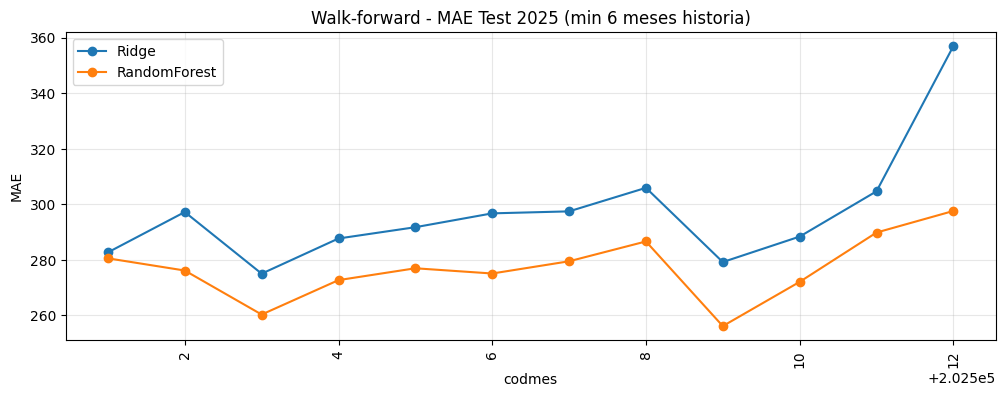

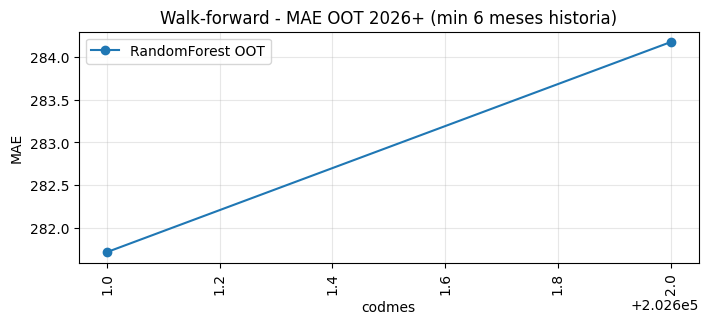

In [44]:
plt.figure(figsize=(12,4))
plt.plot(wf_test_ridge["codmes"], wf_test_ridge["MAE"], marker="o", label="Ridge")
plt.plot(wf_test_rf["codmes"], wf_test_rf["MAE"], marker="o", label="RandomForest")
plt.xticks(rotation=90)
plt.title("Walk-forward - MAE Test 2025 (min 6 meses historia)")
plt.xlabel("codmes")
plt.ylabel("MAE")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


plt.figure(figsize=(8,3))
plt.plot(wf_oot_rf["codmes"], wf_oot_rf["MAE"], marker="o", label="RandomForest OOT")
plt.xticks(rotation=90)
plt.title("Walk-forward - MAE OOT 2026+ (min 6 meses historia)")
plt.xlabel("codmes")
plt.ylabel("MAE")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Analisis Grafico - Walk-Forward con Minimo 6 Meses de Historia

### 1. Walk-Forward - Test 2025

El grafico muestra la evolucion mensual del MAE bajo un esquema de reentrenamiento acumulativo, utilizando un minimo de 6 meses de historia.

Observaciones principales:

- RandomForest mantiene menor MAE que Ridge en todos los meses.
- Ridge presenta mayor variabilidad y un incremento marcado hacia finales del periodo.
- RandomForest muestra comportamiento mas estable.
- Ambos modelos presentan fluctuaciones normales asociadas a variaciones mensuales.

Interpretacion tecnica:

El modelo basado en arboles captura mejor las no linealidades y las interacciones entre variables, lo que reduce la sensibilidad a cambios mensuales.

La mayor volatilidad observada en Ridge sugiere que los modelos lineales son mas sensibles a cambios en la distribucion o en la relacion entre variables.

---

### 2. Walk-Forward - OOT 2026+

En el periodo Out-of-Time, el MAE del modelo RandomForest se mantiene dentro de un rango estrecho.

Observaciones principales:

- El error se mantiene estable entre aproximadamente 281 y 284.
- No se observa deterioro abrupto.
- La variacion mensual es limitada.

Interpretacion tecnica:

El comportamiento estable en OOT indica buena capacidad de generalizacion. 
El modelo mantiene consistencia incluso cuando se proyecta a periodos completamente fuera del rango de entrenamiento original.

---

### Conclusion del Walk-Forward

1. El reentrenamiento acumulativo estabiliza el error a medida que aumenta la historia disponible.
2. RandomForest muestra mayor robustez que Ridge bajo esquema dinamico.
3. No se detecta drift severo en el periodo analizado.
4. El modelo es adecuado para un esquema de actualizacion mensual en produccion.

Este analisis confirma que el modelo seleccionado no solo es preciso en evaluacion estatica, sino tambien estable en un entorno de actualizacion continua.

## 16) Ecuacion final (modelo lineal)

Aqui mostramos la ecuacion del **Ridge** entrenado sobre `train + val` (hasta 202512). Los coeficientes estan sobre variables estandarizadas (z-score).

In [45]:
train_hist = df[df["codmes"] <= 202512].copy()
X_hist, y_hist = train_hist[col_num], train_hist[target]

final_ridge = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=10))])
final_ridge.fit(X_hist, y_hist)

beta = final_ridge.named_steps["model"].coef_
b0 = final_ridge.named_steps["model"].intercept_

eq = pd.DataFrame({"feature": col_num, "beta_std": beta}).sort_values("beta_std", key=np.abs, ascending=False)
print("Intercept (en escala del target):", b0)
eq


Intercept (en escala del target): 4706.483079419783


,feature,beta_std
2,viajes_realizados,1039.773671
5,precio_promedio_viaje,740.451129
6,incentivo_bono,106.620947
4,cancelaciones_pct,-31.126499
3,rating_promedio,25.414356
1,horas_conectado,18.315279
7,combustible_indice,-17.450324
0,antiguedad_meses,1.096872



## Ecuacion Formal del Modelo Ridge

El modelo corresponde a una regresion lineal con regularizacion L2 (Ridge), entrenada sobre variables estandarizadas.

---

### 1. Transformacion de las variables

Cada variable explicativa fue estandarizada mediante la transformacion z-score:

$$
Z_i = \frac{x_i - \mu_i}{\sigma_i}
$$

donde:

- $x_i$ es el valor observado de la variable $i$  
- $\mu_i$ es la media de la variable $x_i$  
- $\sigma_i$ es la desviacion estandar de $x_i$

Esta transformacion centra las variables en cero y las escala a varianza unitaria.

---

### 2. Forma general del modelo

El modelo Ridge puede expresarse como:

$$
\hat{y} = \beta_0 + \sum_{i=1}^{p} \beta_i Z_i
$$

donde:

- $\beta_0$ es el intercepto  
- $\beta_i$ son los coeficientes estandarizados  
- $Z_i$ son las variables transformadas  

En notacion vectorial:

$$
\hat{y} = \beta_0 + \boldsymbol{\beta}^\top \mathbf{Z}
$$

---
### Coeficientes estandarizados (beta_std)

| Variable              | beta_std  | Interpretacion del signo |
|-----------------------|----------:|--------------------------|
| viajes_realizados     | 1039.77   | Aumenta el ingreso       |
| precio_promedio_viaje | 740.45    | Aumenta el ingreso       |
| incentivo_bono        | 106.62    | Aumenta el ingreso       |
| cancelaciones_pct     | -31.13    | Reduce el ingreso        |
| rating_promedio       | 25.41     | Aumenta el ingreso       |
| horas_conectado       | 18.32     | Aumenta el ingreso       |
| combustible_indice    | -17.45    | Reduce el ingreso        |
| antiguedad_meses      | 1.10      | Impacto marginal         |


### 3. Ecuacion estimada

Sustituyendo los valores obtenidos:

$$
\begin{aligned}
\hat{y} =\;& 4706.48 \\
&+ 1039.77\, Z_{viajes\_realizados} \\
&+ 740.45\, Z_{precio\_promedio\_viaje} \\
&+ 106.62\, Z_{incentivo\_bono} \\
&- 31.13\, Z_{cancelaciones\_pct} \\
&+ 25.41\, Z_{rating\_promedio} \\
&+ 18.32\, Z_{horas\_conectado} \\
&- 17.45\, Z_{combustible\_indice} \\
&+ 1.10\, Z_{antiguedad\_meses}
\end{aligned}
$$

---

### 4. Interpretacion Formal

Cada coeficiente $\beta_i$ representa el cambio esperado en el ingreso mensual ante un incremento de una desviacion estandar en la variable correspondiente, manteniendo las demas constantes.

En terminos estructurales, las variables dominantes del modelo son:

$$
viajes\_realizados \quad \text{y} \quad precio\_promedio\_viaje
$$

---

### 5. Formulacion del Problema Ridge

El modelo Ridge estima los coeficientes resolviendo:

$$
\min_{\boldsymbol{\beta}}
\left(
\sum_{i=1}^{n} (y_i - \hat{y}_i)^2
+ \lambda \sum_{j=1}^{p} \beta_j^2
\right)
$$

donde:

- $\lambda$ controla el grado de penalizacion L2  
- La penalizacion reduce la magnitud de los coeficientes  
- Se mejora la estabilidad y se reduce la varianza del modelo

## 17) Resumen ejecutivo (que te llevas para clase)

- **VIF** te muestra si las variables numericas estan pisandose entre si (multicolinealidad).  
- **Regularizacion** (Ridge/Lasso/ElasticNet) estabiliza coeficientes y mejora generalizacion en datasets con colinealidad.  
- **Validacion temporal** (2025) + metricas por mes = backtesting realista.  
- **Rolling window** y **walk-forward** simulan produccion: el mundo cambia y el modelo se recalibra.  
- **Permutation Importance** + **SHAP** te dan interpretabilidad solida para modelos no lineales.
